In [35]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torch import optim
from torchvision import transforms
import torchvision

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [36]:
class CustomDataset(Dataset):
    def __init__(self, ds_dir, annotations_dir, transform=None):
        self.ds_dir = ds_dir
        self.img_notes = pd.read_csv(annotations_dir)
        self.transform = transform
    
    def __len__(self):
        return len(self.img_notes)

    def __getitem__(self, idx):
        img_path = self.img_notes.iloc[idx].example_path
        img = read_image(os.path.join(self.ds_dir, img_path))
        label = self.img_notes.iloc[idx].label
        if self.transform:
            img = self.transform(img)
        return img, label

In [41]:
transform = transforms.Compose(
    [transforms.ToPILImage(),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

trainset = CustomDataset('', 'train.csv', transform)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = CustomDataset('', 'test.csv', transform)
testloader = DataLoader(trainset, batch_size=batch_size, shuffle=False)

AttributeError: 'CustomDataset' object has no attribute 'to'

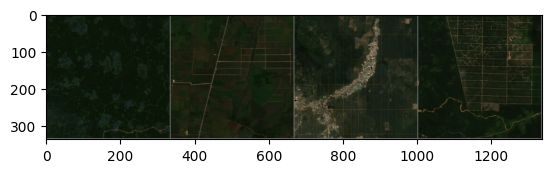

2 0 0 0


In [29]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{labels[j]}' for j in range(batch_size)))

In [38]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(102400, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net().to(device)

In [39]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [42]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 != 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

KeyboardInterrupt: 